# `raman_rabi` documentation

Here are instructions and examples for using the `raman_rabi` package developed by Taylor Patti, Jamelle Watson-Daniels, and Soumya Ghosh for Prof. Manoharan's PHYS 201: Statistics for Physicists course at Harvard.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import raman_rabi
import numpy as np
from raman_rabi import RRDataContainer
from raman_rabi import rr_model

## Signs of life

Having installed the package, we first go to the root directory and run the unit tests:

In [9]:
!nosetests

.....
----------------------------------------------------------------------
Ran 5 tests in 0.695s

OK


Now try importing the package itself and running its test function:

In [2]:


print(raman_rabi.testing.hello())

>>> Hello from raman_rabi!


## Week 1 Model

We want to know if the functional form of the electronic-nuclear flip-flop transition in the Raman-Rabi NV center protocol [arXiv:1808.04346]. The data we are interested in is the change in $m_N = +1$ and $m_s = 0$ nuclear spin populations as a function of Raman-Rabi pulse length in Fig. 4.

It is hypothesized by the paper that this behavior is weakly driven, over-damped Raman-Rabi oscillations. That is, partial coherent transitions between the two nuclear spin populations marred by various sources of state decay and decoherence. The ideal theoretical model proposed for the nuclear spin specific fluorescence for spin $m_N$ is, $I_T^{m_N}(t)$, is described by

$$I_T^{m_N}(t) = B_G + A_p e^{-\Gamma_p t} + A_h \cos\left( \Omega_h t \right) e^{-\Gamma_{deph} t},$$

where $B_G$ is the background population/fluorescence, $A_p$ is the strength at which parasitic transitions remove states from the cycle (i.e. into $m_s = -1$ or $m_N = -1$ states, $\Gamma_p$ is the rate at which this parasitic loss occurs, $A_h$ is the strength at which the hyperfine interaction induces this transition, $\Omega_h$ is the rate at which the hyperfine transition occurs, and $\Gamma_{deph}$ is the rate of dephasing in this coherent oscillation.

This week, we will be focusing on a basic analysis where we will average over all of our data points for each $m_S$ and then consider our full signal model as

$$I(t) = I_T^{m_N}(t) + \eta_{shot}(t)$$

where $\eta_{shot}(t)$ is a random variable describing the measurement shot noise (Poissonian distribution) of mean $\lambda = \sqrt{I_T^{m_N}(t)}$ is. This is because the expectation value of shot noise is equal to the square root of the ideal signal, the shot noise is described by a Poissonian distribution, and the expectation value of the Poissonian distribution is its mean. HOWEVER, as the fluoresence data is taken as a continuum (not single photon counting) we will take the limit of large counts of a Poissonian distribution and obtain a Gaussian distribution for the shot noise random variable.

## Bayesian Inference
Consider the test data with nominal parameters, determined in the previous work. In order to illustrate the suitability of this functional form for these test data, we plot the model with nominal parameters against the fluorescence data averaged over all runs. In an effort to understand our likelihood function, we vary $B_G$ and calculate the likelihood. Then, we do the same for $\Gamma_p$.

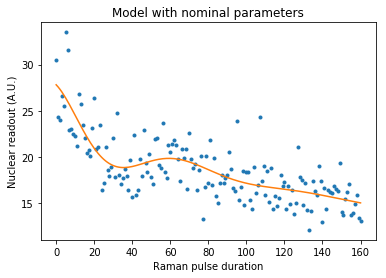

In [51]:
testfilepath = "testdata/21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt"
s = RRDataContainer(testfilepath)
mN1_data = s
time_min = 0
time_max = 40
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871

plotting_BG = 6.1
plotting_Ap = 16.6881
plotting_Ah = 5.01886
s_likelihood, prediction = rr_model.likelihood_mN1(mN1_data, time_min, time_max, plotting_BG, 
                                                   plotting_Ap, Gammap, plotting_Ah, Omegah, Gammadeph)

conversion = 1000 # conversion factor between fluorescence and number of nuclei
averaged_data = conversion*s.get_df().mean(axis=0)
plt.plot(averaged_data,linestyle='None',marker='.')
plt.plot(prediction)
plt.title('Model with nominal parameters')
plt.xlabel('Raman pulse duration')
plt.ylabel('Nuclear readout (A.U.)')
plt.show()

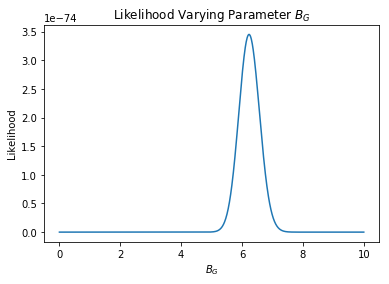

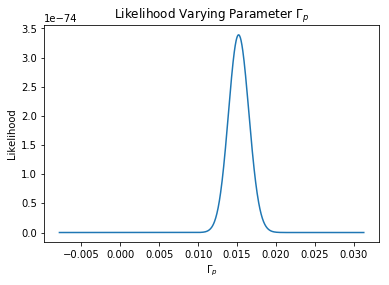

In [40]:
# plot likelihood as a function of the background fluorescence parameter
npoints = 1000
BG_range = np.linspace(0,10,npoints)
gammap_range = np.linspace(-Gammap/2,2*Gammap,npoints)

# thisBG, thisData = np.meshgrid(BG_range, s)
likelihoods_bg = []
likelihoods_gp = []
mus_bg = []
mus_gp = []
for i in range(npoints):
    bgLikelihood, mu1 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG_range[i], Ap, Gammap, Ah, Omegah, Gammadeph)
    likelihoods_bg.append(bgLikelihood)
    gpLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, gammap_range[i], Ah, Omegah, Gammadeph)
    likelihoods_gp.append(gpLikelihood)

plt.plot(BG_range,likelihoods_bg)
plt.title(r"Likelihood Varying Parameter $B_G$")
plt.xlabel(r"$B_G$")
plt.ylabel("Likelihood")
plt.show()

plt.plot(gammap_range,likelihoods_gp)
plt.title(r"Likelihood Varying Parameter $\Gamma_p$")
plt.xlabel(r"$\Gamma_p$")
plt.ylabel("Likelihood")
plt.show()